Authors: Bex Dunn, Neil Symington, Claire Krause, Leo Lymburner

### get some modules

In [2]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import matplotlib.pyplot as plt

#dealing with system commands
import sys
import os.path

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
from RainfallTools import load_rainfall, calculate_residual_mass_curve

## Choose a time period and location to calculate residual mass curve.
 - Note: please select whole months here, not days, as a month with only two days may negatively affect your mass residual curve

In [9]:
## Choose a q

query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2012-01', '2014-01')
        }

### load rainfall data

In [10]:
rainfall = load_rainfall(query)

## calculate rainfall mass residual

In [ ]:
'''This function calculates the residual mass rainfall curve
:param a: '''
import datacube
import numpy as np
import xarray as xr

## resample rainfall data to month start

In [23]:
#resample rainfall data to month start
rainfall = rainfall.resample(time ='MS', keep_attrs=True).sum()

In [28]:
cumulative_rainfall = rainfall.cumsum(dim='time',keep_attrs=True)

In [39]:
rainfall.groupby('time.month')

In [44]:
monthly_mean_rainfall = rainfall.groupby('time.month').mean()

In [45]:
monthly_mean_rainfall

<xarray.Dataset>
Dimensions:   (month: 12)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    rainfall  (month) float64 24.8 558.8 0.0 44.5 5.683 20.75 0.0 1.808 3.0 ...

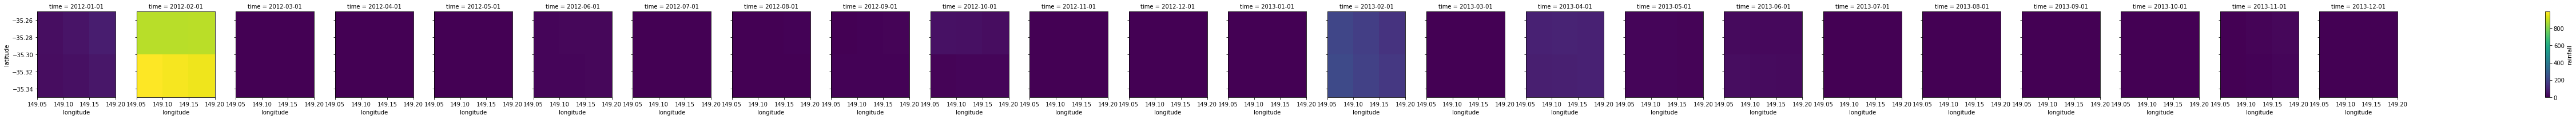

In [32]:
rainfall.rainfall.plot(col='time')

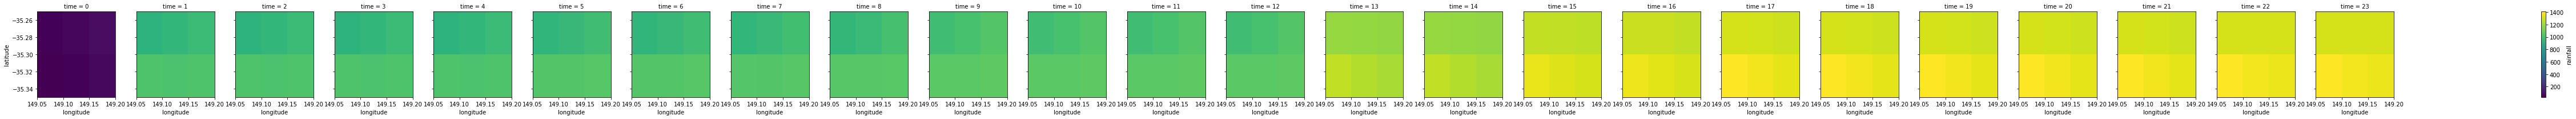

In [31]:
cumulative_rainfall.rainfall.plot(col='time')

In [62]:
# The mass residual curve is the difference between the cumulative rainfall data and the cumulative
# rainfall one would get iff the average always occured
mass_res_curve = cum_rf_xr - cum_ave_xr

NameError: name 'cum_ave_xr' is not defined

In [ ]:
def calculate_residual_mass_curve(a):
    '''This function calculates the residual mass rainfall curve
    :param a: '''
    
    #resample rainfall data to month start
    a = a.resample('MS', dim='time', how='sum', keep_attrs=True) 
    # find the number of time steps (ie. years)
    n = len(a.rainfall.time)/12
    
    # First calculate a cumulative rainfall xarray from the rainfall data
    
    arr = a.rainfall.values
    
    cum_rf = np.cumsum(arr, axis = 0)
    
    cum_rf_xr = xr.DataArray(cum_rf, dims = ('time', 'latitude', 'longitude'),
                            coords = [a.time, a.latitude, a.longitude])
    
    # NOw we will calculate a cumulative rainfall assuming average rainfall on a month by month basis
    # Find the average of all months
    ave_months = a.rainfall.groupby('time.month').mean('time').values
   
    # In the case that we are not starting from January we will need to reorder the array
    
    start_month = a.time[0].dt.month.values - 1
    
    ave_month = np.concatenate((ave_months[start_month:,:,:], ave_months[0:start_month,:,:]), axis = 0)

    
    # Tile an array so that we can run a cumulative sum on it
    tiled_ave = np.tile(ave_months, (round(n), 1, 1))
    
    # In the case that we have residual months remove them from the tiled array
    if (n).is_integer() == False:
        month_remainder = int(round((n%1) * 12))

        tiled_ave = tiled_ave[:int(-month_remainder),:,:]
        
    # Generate the cumulative sum of rainfall one would get assuming average rainfall every month
    cum_ave = np.cumsum(tiled_ave, axis = 0)
    
    cum_ave_xr = xr.DataArray(cum_ave, dims = ('time', 'latitude', 'longitude'),
                              coords = [a.time, a.latitude, a.longitude])
    
    # The mass residual curve is the difference between the cumulative rainfall data and the cumulative
    # rainfall one would get iff the average always occured
    mass_res_curve = cum_rf_xr - cum_ave_xr
    
    return mass_res_curve


## calculate metrics based on rainfall
- increasing and decreasing periods
- wet year after dry years
- dry year after wet years
-

## calculate metrics based on residual rainfall
- increasing and decreasing periods
- wet year after dry years
- dry year after wet years


## calculate seasonality
- Koppen climate region (use notebook to follow decision tree - requires climate data)
- Summer dominant, Summer, Uniform, Winter, Winter dominant #
- TROP SOI value
- IOD /SAM indices
"During El Niño, rainfall in eastern Australian is typically below average during winter and spring. A neutral ENSO phase has little effect on Australian climate."Bureau of meteorology http://www.bom.gov.au/climate/enso/  

In [39]:
# Calculate failed wet seasons - calculate total wet season + dry season rainfalls
# (end of wet season rainfalls?)